# Bayesian optimisation

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)

np.random.seed(7)

In [29]:
noise_level = 0.01

def f(x):
    return (np.sin(5 * x) * (1 - np.tanh(x ** 2))).ravel()

def noise_f(x, sigma=noise_level):
    return f(x) + np.random.randn(len(x)) * sigma

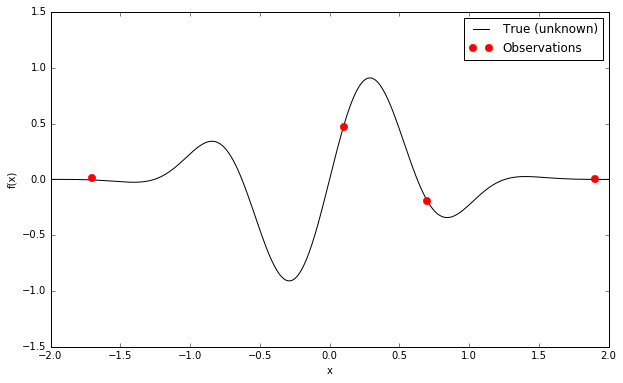

In [30]:
x = np.linspace(-2, 2, 400)

plt.plot(x, f(x), "k", label="True (unknown)")

xi = np.array([-1.7, 0.1, 0.7, 1.9]).reshape(-1, 1)
yi = noise_f(xi)
plt.plot(xi.ravel(), yi, "r.", markersize=15, label="Observations")

plt.xlabel("x")
plt.ylabel("f(x)")
plt.ylim(-1.5, 1.5)
plt.xlim(-2, 2)
plt.legend(loc="best")
plt.savefig("fig1.pdf")
plt.show()

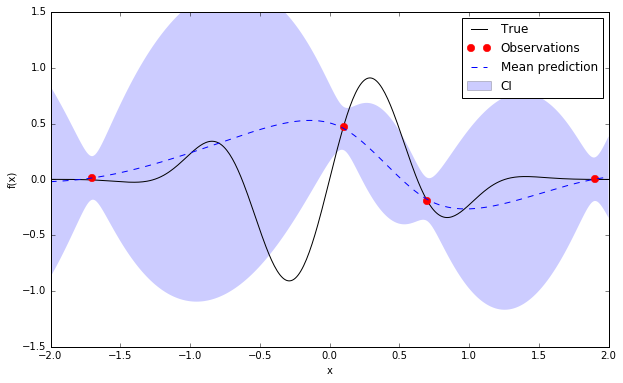

In [31]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

kernel = Matern(length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_level, random_state=0)
gp.fit(xi, yi)

x = np.linspace(-2, 2, 400)
y_pred, sigma = gp.predict(x[:, None], return_std=True)

plt.plot(x, f(x), "k", label="True")
plt.plot(xi, yi, "r.", markersize=15, label="Observations")
plt.plot(x, y_pred, "b--", label="Mean prediction")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma, (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc='b', ec='None', label='CI')

plt.xlabel("x")
plt.ylabel("f(x)")
plt.ylim(-1.5, 1.5)
plt.xlim(-2, 2)
plt.legend(loc="best")
plt.savefig("fig2.pdf")
plt.show()

In [32]:
from scipy.stats import norm

def probability_of_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return norm.cdf(gamma_x)


def expected_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return sigma_x * (gamma_x * norm.cdf(gamma_x) + norm.pdf(gamma_x))


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=1.0):
    return mu_x + kappa * sigma_x

In [33]:
def plot(xi, yi, gp, acq, next_x=None, filename=None):
    x = np.linspace(-2, 2, 400)
    y_pred, sigma = gp.predict(x[:, None], return_std=True)

    plt.plot(x, f(x), "k", label="True")
    plt.plot(xi, yi, "r.", markersize=15, label="Observations")
    plt.plot(x, y_pred, "b--", label="Mean prediction")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma, (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.2, fc='b', ec='None', label='CI')
    
    if acq == upper_confidence_bound:
        plt.plot(x, acq(y_pred, sigma, yi.max()), "g", label="u(x)")
        
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.ylim(-1.5, 1.5)
    plt.xlim(-2, 2)
    plt.legend(loc="best")
    
    if acq != upper_confidence_bound:
        plt.twinx()
        plt.plot(x, acq(y_pred, sigma, yi.max()), "g", label="acquisition")
        plt.legend(loc="best")
        
    if next_x:
        y_pred, sigma = gp.predict(next_x[:, None], return_std=True)
        plt.plot([next_x], acq(y_pred, sigma, yi.max()), "g.", markersize=15)
        
    plt.title(r"$x_t^+ = %.4f$" % xi[np.argmax(yi)])

    if filename:
        plt.savefig(filename)
        
    plt.show()

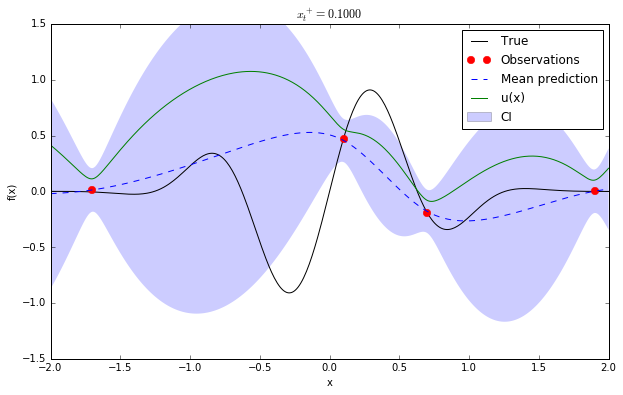

In [34]:
plot(xi, yi, gp, upper_confidence_bound, filename="fig3.pdf")

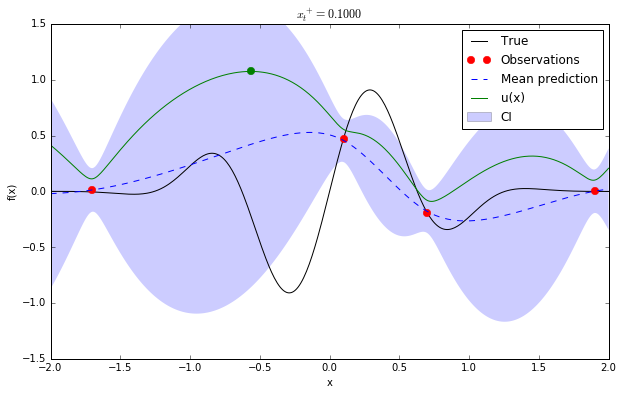

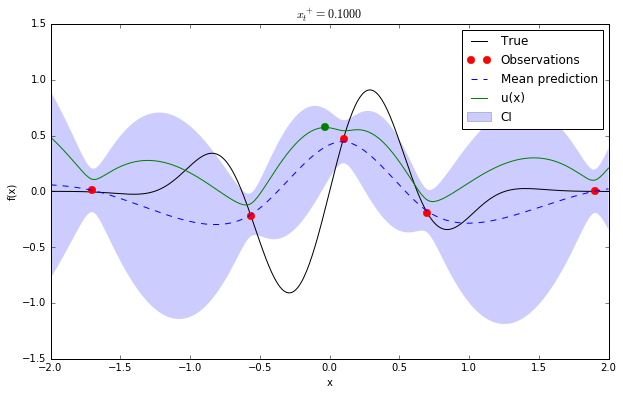

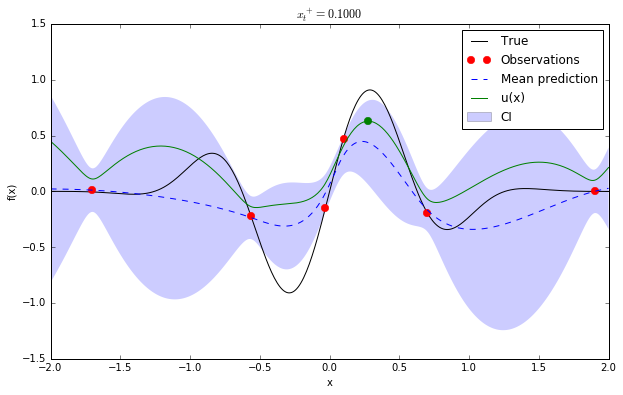

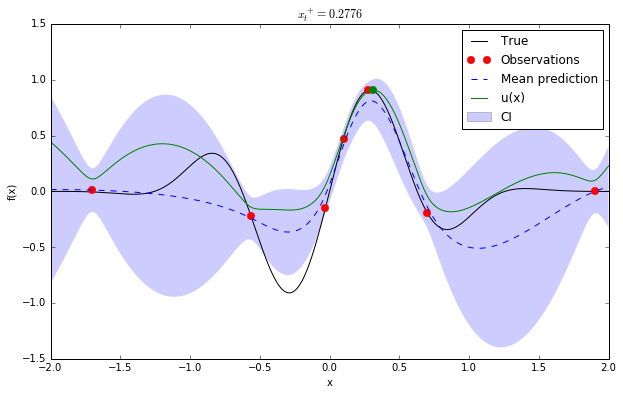

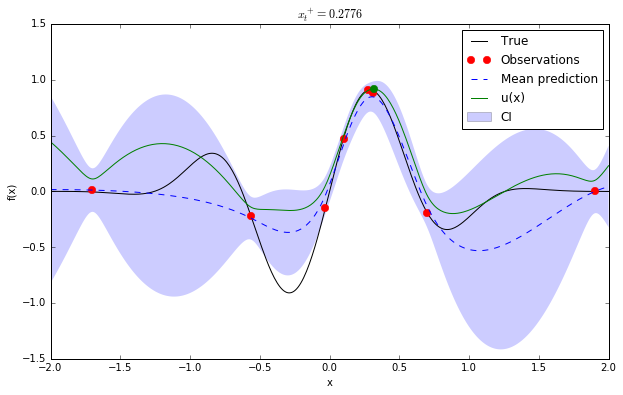

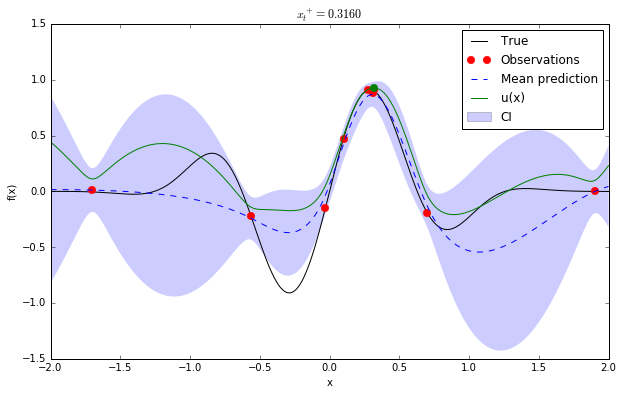

In [35]:
from scipy.optimize import minimize

acq = upper_confidence_bound

def next_x(xi, yi, gp):
    best_value = np.inf

    for x0 in np.linspace(-2, 2, 10):
        def obj(x):
            x = np.array(x).reshape(1, 1)
            mu_x, sigma_x = gp.predict(x, return_std=True)
            return -acq(mu_x, sigma_x, np.max(yi))

        res = minimize(obj, x0, bounds=[(-2, 2)])

        if res.fun < best_value:
            best_value = res.fun
            query_point = res.x

    return query_point

for i in range(6):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_level, random_state=0)
    gp.fit(xi, yi)
    
    next_point = next_x(xi, yi, gp)
    plot(xi, yi, gp, acq, next_point, filename="fig4-%d.pdf" % i)
    
    xi = np.vstack((xi, next_point))
    yi = np.concatenate((yi, noise_f(xi[-1])))

In [36]:
xi[np.argmax(yi)], np.max(yi)

(array([ 0.31601894]), 0.9106003775564081)